<a href="https://colab.research.google.com/github/Malek9876/LLM-Based-Text-Classification/blob/main/Sentiment_Analysis_Using_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
%pip install --upgrade pip
%pip install kagglehub
import kagglehub
path = kagglehub.dataset_download('abhi8923shriv/sentiment-analysis-dataset')

# Install the required libraries
%pip install pandas numpy nltk scikit-learn transformers matplotlib seaborn
#%pip uninstall torch torchvision torchaudio -y
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


print('Data source import complete.')


Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.
Data source import complete.


# Sentiment Analysis on Kaggle sentiment analysis dataset
sentiment analysis tasks on kaggle sentiment analysis dataset using simple machine learning model: Naive bayes


## Including needed libraries

In [2]:
# --------------- MAIN LIBRARIES ------------------

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


# --------------- HELPING LIBRARIES ----------------
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# ------------- Pytorch Librairies ---------------
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel



In [3]:
torch.cuda.is_available()

True

## Uploading Data

In [4]:
train_dataset = path+'/train.csv'
test_dataset = path+'/test.csv'

# Check if the path exists
print (os.path.exists(train_dataset))
print (os.path.exists(test_dataset))

True
True


In [5]:
# Load the CSV file into a DataFrame
train_df = pd.read_csv(train_dataset, encoding='ISO-8859-1')
test_df = pd.read_csv(test_dataset, encoding='ISO-8859-1')


In [ ]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


## Data Preprocessing

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


#### Handling null values

In [ ]:
train_df.isnull().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [ ]:
train_df = train_df.dropna()
train_df.isnull().sum()

textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [11]:
test_df.isnull().sum()

textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64

In [12]:
test_df = test_df.dropna()
test_df.isnull().sum()

textID              0
text                0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

#### Removing stopwords & lowercase all text

In [13]:
# Download necessary NLTK data
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elyes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# Text preprocessing function that removes stopwords and convert text to lowercase

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text



In [ ]:
# Apply preprocessing on train dataset
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
train_df.head()

In [16]:
# Apply preprocessing on test dataset
test_df['processed_text'] = test_df['text'].apply(preprocess_text)
test_df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0,last session day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0,shanghai also really exciting (precisely -- sk...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0,"recession hit veronique branquinho, quit compa..."
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0,http://twitpic.com/4w75p - like it!!


## Check Imbalancing

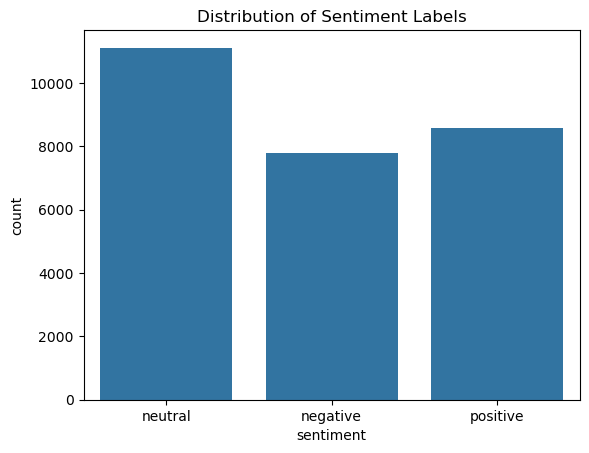

In [17]:
# Distribution of sentiment labels
sns.countplot(x='sentiment', data=train_df)
plt.title("Distribution of Sentiment Labels")
plt.show()

In [18]:
# 1. Transform sentiment into 3 classes
# Example mapping: positive -> 2, neutral -> 1, negative -> 0
sentiment_mapping = {"positive": 2, "neutral": 1, "negative": 0}
train_df["sentiment_class"] = train_df["sentiment"].map(sentiment_mapping)
test_df["sentiment_class"] = test_df["sentiment"].map(sentiment_mapping)

# 2. Extract all the values from the 'processed_text' column into a list
trainval_x = train_df["processed_text"].tolist()
trainval_y = train_df["sentiment_class"].tolist()

train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, test_size=0.25, random_state=42)

test_x = test_df["processed_text"].tolist()
test_y = test_df["sentiment_class"].tolist()

In [19]:
print(len(trainval_x),len(val_x),len(test_x))

27480 6870 3534


In [20]:
# Hyperparameters
PRETRAINED_MODEL = "bert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 64
NUM_CLASSES = 3
LEARNING_RATE = 2e-5
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Extract embeddings for all data
def extract_embeddings(model, dataloader, device):
    """
    Extracts embeddings for all data using a pre-trained BERT model.

    Args:
        model (transformers.BertModel): Pre-trained BERT model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        torch.Tensor: A matrix of size (number_of_samples, embedding_size).
    """
    model.eval()  # Set the model to evaluation mode
    embeddings = []

    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Forward pass through BERT
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output  # CLS token representation

            # Append embeddings to the list
            embeddings.append(pooled_output.cpu())

    # Combine all embeddings into a single matrix
    return torch.cat(embeddings, dim=0)

# Initialize tokenizer, dataset, and dataloader
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
traindataset = TextDataset(train_x, train_y, tokenizer, MAX_LENGTH)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=False)
valdataset = TextDataset(val_x, val_y, tokenizer, MAX_LENGTH)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings
train_embeddings = extract_embeddings(bert, trainloader, device)
train_embeddings =train_embeddings.cpu()

val_embeddings = extract_embeddings(bert, valloader, device)
val_embeddings =val_embeddings.cpu()


In [21]:
print(train_embeddings.size())
print(val_embeddings.size())


torch.Size([20610, 768])
torch.Size([6870, 768])


In [22]:
criterion= nn.CrossEntropyLoss()

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Custom Dataset
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        embeddings = self.embeddings[idx]
        label = self.labels[idx]

        return {
            "input_ids": embeddings.squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Model Definition
class SentimentClassifier(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(SentimentClassifier, self).__init__()

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids):

        # Pass through the fully connected layer
        logits = self.fc(input_ids)
        return logits

# training script

def train( model, train_loader, optimizer, epoch,log_interval=50):
    model.train()
    loss_cpu=0
    correct = 0
    total = 0
    for batch_idx, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, target = data['input_ids'],data['label']
        inputs, target = inputs.cuda(), target.cuda()
        inputs =inputs.detach()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        loss_cpu+= loss.item()
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()

        if batch_idx % log_interval == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, EPOCHS, batch_idx+1,
                    (len(train_loader)//BATCH_SIZE)+1, loss.item(), 100.*correct/total))
            #n_iter=epoch * len(train_loader) + batch_idx

    return loss_cpu/len(train_loader)

# testing script
def test( model, test_loader,epoch):
    model.eval()
    correct = 0
    total = 0
    test_loss_MSE =0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0):
            inputs, target = data['input_ids'],data['label']
            inputs, target = inputs.cuda(), target.cuda()
            outputs  = model(inputs)
            loss = criterion(outputs,target)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += predicted.eq(target.data).cpu().sum()
            test_loss_MSE+= loss.item()

    test_loss_MSE = test_loss_MSE/ len(test_loader)
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), 100.*correct/total))
    return test_loss_MSE, 100.*correct/total

In [ ]:
def __getitem__(self, idx):
    text = self.texts[idx]
    encoding = self.tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=self.max_length,
        return_tensors="pt"
    )
    return {
        "input_ids": encoding["input_ids"].squeeze(0),
        "attention_mask": encoding["attention_mask"].squeeze(0),
        "label": torch.tensor(self.labels[idx], dtype=torch.long)
    }

In [23]:
print ("Let us Train.")
EPOCHS = 50
model = SentimentClassifier(768, NUM_CLASSES).to(device)
model_test = SentimentClassifier(768, NUM_CLASSES).to(device)
best_error = float('inf')
LEARNING_RATE = 1e-3
from torch.optim.lr_scheduler import ReduceLROnPlateau,StepLR

traindataset = EmbeddingDataset(train_embeddings, train_y)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=True)
valdataset = EmbeddingDataset(val_embeddings, val_y)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=True)



optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
#lr_scheduler =  StepLR(optimizer, step_size=20, gamma=0.1)
lr_scheduler = ReduceLROnPlateau(optimizer, 'min', patience=7)

train_history = []
val_history = []
print('----------------------------------------------------------------------------------------------------')
print('3/ training model 1')
print('----------------------------------------------------------------------------------------------------')

iter =0
for epoch in range(EPOCHS):
    loss = train(model, trainloader, optimizer, epoch)
    train_history.append(loss)
    #lr_scheduler.step()
    val_loss= test(model, valloader,epoch)
    val_history.append(val_loss[0])
    lr_scheduler.step(val_loss[0])
    print('lr =',get_lr(optimizer))

    if val_loss[0] <best_error:
        best_error=val_loss[0]
        print('Best RMSE is of : ' + str(best_error), 'for epoch :', epoch,'ERROR TEST = ',val_loss)
        #model_test.parameters()=model.state_dict()
        model_test.load_state_dict(model.state_dict(), strict=True)

print ("Training Done!")

Let us Train.
----------------------------------------------------------------------------------------------------
3/ training model 1
----------------------------------------------------------------------------------------------------
| Epoch [  0/ 50] Iter[  1/  6]		Loss: 1.1099 Acc@1: 43.750%
| Epoch [  0/ 50] Iter[ 51/  6]		Loss: 5.5732 Acc@1: 35.876%
| Epoch [  0/ 50] Iter[101/  6]		Loss: 18.7418 Acc@1: 34.653%
| Epoch [  0/ 50] Iter[151/  6]		Loss: 16.8084 Acc@1: 34.127%
| Epoch [  0/ 50] Iter[201/  6]		Loss: 33.0875 Acc@1: 35.813%
| Epoch [  0/ 50] Iter[251/  6]		Loss: 21.3532 Acc@1: 35.371%
| Epoch [  0/ 50] Iter[301/  6]		Loss: 29.4919 Acc@1: 34.396%

| Validation Epoch #0			Loss: 39.3741 Acc@1: 30.99%
lr = 0.001
Best RMSE is of : 39.305991102147985 for epoch : 0 ERROR TEST =  (39.305991102147985, tensor(30.9898))
| Epoch [  1/ 50] Iter[  1/  6]		Loss: 36.4442 Acc@1: 35.938%
| Epoch [  1/ 50] Iter[ 51/  6]		Loss: 29.8762 Acc@1: 33.150%
| Epoch [  1/ 50] Iter[101/  6]		Loss: 39

## Evaluation

In [24]:
testdataset = TextDataset(test_x,test_y, tokenizer, MAX_LENGTH)
testloader = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings

test_embeddings = extract_embeddings(bert, testloader, device)
test_embeddings =test_embeddings.cpu()
print('==================== ')
print('Test set = ')
testdataset = EmbeddingDataset(test_embeddings, test_y)
testdataset = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=True)
test_loss,accu = test(model, testdataset,epoch)
print('==================== ')

Test set = 

| Validation Epoch #49			Loss: 6.5953 Acc@1: 49.66%


## Questions

**q0/  please analyse the dataset with differents classical machine learning model**

**q1/  please perform a classification with differents classical machine learning model and analyse the performences**

**q2/  please perform a classification with a MLP?**

**q3/  please analyse all the performences and explain which is the best**

**q4/  please use an LLM compare your performences to a LLM**

**q5/  please explain why I choose a BERT embedding instead of the raw text**

**q6/  please read the BERT paper and explain the BERT architecture**

**q7/  please finetue with LORA an LLM to classify the sentiment (optional)**

In [26]:
PRETRAINED_MODEL = "bert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 64
NUM_CLASSES = 3
LEARNING_RATE = 2e-5
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset

tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
traindataset = TextDataset(train_x, train_y, tokenizer, MAX_LENGTH)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=False)
valdataset = TextDataset(val_x, val_y, tokenizer, MAX_LENGTH)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings
train_embeddings = extract_embeddings(bert, trainloader, device)
train_embeddings =train_embeddings.cpu()

val_embeddings = extract_embeddings(bert, valloader, device)
val_embeddings =val_embeddings.cpu()


print(train_embeddings.size())
print(val_embeddings.size())


criterion= nn.CrossEntropyLoss()

# Model Definition

# training script

# testing script

print ("Let us Train.")
EPOCHS = 50
model = SentimentClassifier(1024, NUM_CLASSES).to(device)
model_test = SentimentClassifier(1024, NUM_CLASSES).to(device)
best_error = float('inf')
LEARNING_RATE = 1e-3
from torch.optim.lr_scheduler import ReduceLROnPlateau,StepLR

traindataset = EmbeddingDataset(train_embeddings, train_y)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=True)
valdataset = EmbeddingDataset(val_embeddings, val_y)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=True)



optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
#lr_scheduler =  StepLR(optimizer, step_size=20, gamma=0.1)
lr_scheduler = ReduceLROnPlateau(optimizer, 'min', patience=7)

train_history = []
val_history = []

print('----------------------------------------------------------------------------------------------------')
print('3/ training model 2')
print('----------------------------------------------------------------------------------------------------')

iter =0

for epoch in range(EPOCHS):
    loss = train(model, trainloader, optimizer, epoch)
    train_history.append(loss)
    #lr_scheduler.step()
    val_loss= test(model, valloader,epoch)
    val_history.append(val_loss[0])
    lr_scheduler.step(val_loss[0])
    print('lr =',get_lr(optimizer))

    if val_loss[0] <best_error:
        best_error=val_loss[0]
        print('Best RMSE is of : ' + str(best_error), 'for epoch :', epoch,'ERROR TEST = ',val_loss)
        #model_test.parameters()=model.state_dict()
        model_test.load_state_dict(model.state_dict(), strict=True)

print ("Training Done!")

testdataset = TextDataset(test_x,test_y, tokenizer, MAX_LENGTH)
testloader = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings

test_embeddings = extract_embeddings(bert, testloader, device)
test_embeddings =test_embeddings.cpu()
print('==================== ')
print('Test set = ')
testdataset = EmbeddingDataset(test_embeddings, test_y)
testdataset = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=True)
test_loss,accu = test(model, testdataset,epoch)

print('==================== ')

model.safetensors:  18%|#7        | 241M/1.34G [00:00<?, ?B/s]

c:\Users\elyes\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\elyes\.cache\huggingface\hub\models--bert-large-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


torch.Size([20610, 1024])
torch.Size([6870, 1024])
Let us Train.
----------------------------------------------------------------------------------------------------
3/ training model 2
----------------------------------------------------------------------------------------------------
| Epoch [  0/ 50] Iter[  1/  6]		Loss: 1.0998 Acc@1: 29.688%
| Epoch [  0/ 50] Iter[ 51/  6]		Loss: 6.8486 Acc@1: 33.732%
| Epoch [  0/ 50] Iter[101/  6]		Loss: 17.3220 Acc@1: 35.566%
| Epoch [  0/ 50] Iter[151/  6]		Loss: 45.1580 Acc@1: 33.599%
| Epoch [  0/ 50] Iter[201/  6]		Loss: 34.1034 Acc@1: 33.341%
| Epoch [  0/ 50] Iter[251/  6]		Loss: 55.8790 Acc@1: 34.574%
| Epoch [  0/ 50] Iter[301/  6]		Loss: 86.1773 Acc@1: 34.240%

| Validation Epoch #0			Loss: 79.1753 Acc@1: 28.47%
lr = 0.001
Best RMSE is of : 81.75154304504395 for epoch : 0 ERROR TEST =  (81.75154304504395, tensor(28.4716))
| Epoch [  1/ 50] Iter[  1/  6]		Loss: 75.9435 Acc@1: 34.375%
| Epoch [  1/ 50] Iter[ 51/  6]		Loss: 16.8787 Acc@1: 

In [27]:
#printing the model
print(model)

SentimentClassifier(
  (fc): Linear(in_features=1024, out_features=3, bias=True)
)


In [28]:
%pip install transformers peft datasets torch


  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 0.24.6
    Uninstalling huggingface_hub-0.24.6:
      Successfully uninstalled huggingface_hub-0.24.6


In [29]:
from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# 1. LoRA Configuration
lora_config = LoraConfig(
    r=16,  # rank of update matrices
    lora_alpha=32,  # scaling factor
    target_modules=["query", "value"],  # layers to apply LoRA
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

# 2. Load base model
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_CLASSES
)

# 3. Create LoRA model
lora_model = get_peft_model(model, lora_config)
print(f"Trainable parameters: {lora_model.print_trainable_parameters()}")

# 4. Training arguments
training_args = TrainingArguments(
    output_dir="./lora_sentiment_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# 5. Format dataset
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 6. Prepare datasets
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)
train_dataset = SentimentDataset(train_x, train_y, tokenizer)
val_dataset = SentimentDataset(val_x, val_y, tokenizer)

# 7. Initialize trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# 8. Train
trainer.train()

# 9. Save model
lora_model.save_pretrained("./lora_sentiment_model_final")

# 10. Inference
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = lora_model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return predictions

Error importing huggingface_hub._snapshot_download: cannot import name 'GatedRepoError' from 'huggingface_hub.errors' (c:\Users\elyes\anaconda3\Lib\site-packages\huggingface_hub\errors.py)


ImportError: cannot import name 'GatedRepoError' from 'huggingface_hub.errors' (c:\Users\elyes\anaconda3\Lib\site-packages\huggingface_hub\errors.py)

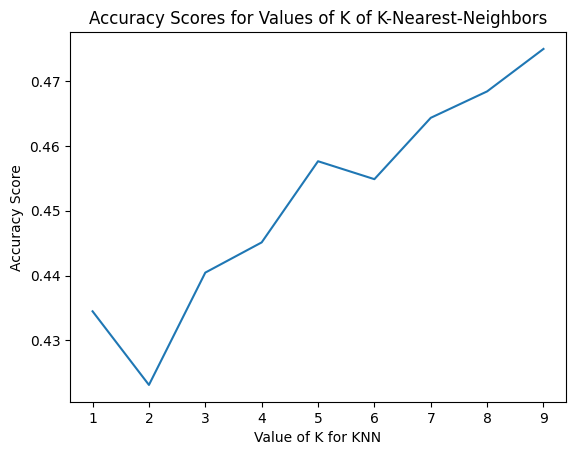

Accuracy of KNN model is : 0.46066779852857953


In [26]:
## KNN
from sklearn.neighbors import KNeighborsClassifier
# Elbow method to find the best K
k_range = range(1, 10)
scores = []
for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(train_embeddings, train_y)
    knn_predictions = knn_model.predict(val_embeddings)
    scores.append(accuracy_score(val_y, knn_predictions))
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of K of K-Nearest-Neighbors')
plt.show()
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_embeddings, train_y)
yhat = knn_model.predict(test_embeddings)
print('Accuracy of KNN model is :',accuracy_score(test_y, yhat))

In [ ]:
## QUESTION 0 and 1 :
import sklearn
## LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

for solver in ['newton-cg', 'lbfgs', 'sag', 'saga']:
    logistic_model = LogisticRegression(max_iter=1000, solver=solver,C=10, random_state=42)
    logistic_model.fit(train_embeddings, train_y)
    logistic_predictions = logistic_model.predict(val_embeddings)
    logistic_accuracy = accuracy_score(val_y, logistic_predictions)
    print(f'Logistic Regression ({solver}) Accuracy: {logistic_accuracy:.2f}')
    yhat = logistic_model.predict(test_embeddings)
    acc = accuracy_score(test_y, yhat)
    print(f'Logistic Regression ({solver}) Accuracy: {acc:.2f}')


Logistic Regression (newton-cg) Accuracy: 0.64
Logistic Regression (lbfgs) Accuracy: 0.64
Logistic Regression (sag) Accuracy: 0.64


In [28]:
## DECISION TREE
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(train_embeddings, train_y)
decision_tree_predictions = decision_tree_model.predict(val_embeddings)
decision_tree_accuracy = accuracy_score(val_y, decision_tree_predictions)
print(f'Decision Tree Validation Accuracy: {decision_tree_accuracy:.2f}')
yhat = decision_tree_model.predict(test_embeddings)
acc = accuracy_score(test_y, yhat)
print(f'Decision Tree Test Accuracy: {acc:.2f}')

Decision Tree Validation Accuracy: 0.42
Decision Tree Test Accuracy: 0.42


In [29]:
## RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42, n_estimators=100,)
random_forest_model.fit(train_embeddings, train_y)
random_forest_predictions = random_forest_model.predict(val_embeddings)
random_forest_accuracy = accuracy_score(val_y, random_forest_predictions)
print(f'Random Forest Validation Accuracy: {random_forest_accuracy:.2f}')
yhat = random_forest_model.predict(test_embeddings)
acc = accuracy_score(test_y, yhat)
print(f'Random Forest Test Accuracy: {acc:.2f}')

Random Forest Validation Accuracy: 0.54
Random Forest Test Accuracy: 0.55


In [ ]:
## SVM with parameters and hyperparameters

from sklearn.svm import SVC
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    for C in [0.1, 1, 10]:
        svm_model = SVC(kernel=kernel, C=C, random_state=42)
        svm_model.fit(train_embeddings, train_y)
        svm_predictions = svm_model.predict(val_embeddings)
        svm_accuracy = accuracy_score(val_y, svm_predictions)
        print(f'SVM ({kernel}, C={C}) Validation Accuracy: {svm_accuracy:.2f}')
        yhat = svm_model.predict(test_embeddings)
        acc = accuracy_score(test_y, yhat)
        print(f'SVM ({kernel}, C={C}) Test Accuracy: {acc:.2f}')



SVM (linear, C=0.1) Validation Accuracy: 0.63
SVM (linear, C=0.1) Test Accuracy: 0.64
SVM (linear, C=1) Validation Accuracy: 0.65
SVM (linear, C=1) Test Accuracy: 0.65


In [26]:

# Assuming you have these already:
# train_embeddings  (Tensor)
# train_y          (List or numpy array)
# val_embeddings    (Tensor)
# val_y            (List or numpy array)
# test_embeddings   (Tensor)
# test_y           (List or numpy array)
# NUM_CLASSES      (int, the number of sentiment classes)
# device           (torch.device("cuda" if torch.cuda.is_available() else "cpu"))
from torch.utils.data import DataLoader, TensorDataset

# 1. Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(train_embeddings, torch.tensor(train_y, dtype=torch.long))
val_dataset = TensorDataset(val_embeddings, torch.tensor(val_y, dtype=torch.long))
test_dataset = TensorDataset(test_embeddings, torch.tensor(test_y, dtype=torch.long))

BATCH_SIZE = 128  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# 2. Define the MLP Model
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model
input_size = train_embeddings.shape[1]
hidden_size = 512  # Experiment with this value
mlp_model = MLPClassifier(input_size, hidden_size, NUM_CLASSES).to(device)


# 3. Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)  # Adjust learning rate

EPOCHS = 10  # Adjust as needed
for epoch in range(EPOCHS):
    for batch in train_loader:
        embeddings, labels = batch
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mlp_model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    with torch.no_grad():
        val_predictions = []
        for batch in val_loader:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = mlp_model(embeddings)
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.cpu().numpy())
        val_accuracy = accuracy_score(val_y, val_predictions)
        print(f"Epoch {epoch+1}/{EPOCHS}, Validation Accuracy: {val_accuracy:.4f}")


# 4. Evaluation on Test Set
with torch.no_grad():
    test_predictions = []
    for batch in test_loader:
        embeddings, labels = batch
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = mlp_model(embeddings)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
    test_accuracy = accuracy_score(test_y, test_predictions)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(test_y, test_predictions)) # Detailed report

Epoch 1/10, Validation Accuracy: 0.4473
Epoch 2/10, Validation Accuracy: 0.3728
Epoch 3/10, Validation Accuracy: 0.4437
Epoch 4/10, Validation Accuracy: 0.5361
Epoch 5/10, Validation Accuracy: 0.5876
Epoch 6/10, Validation Accuracy: 0.4028
Epoch 7/10, Validation Accuracy: 0.5907
Epoch 8/10, Validation Accuracy: 0.6044
Epoch 9/10, Validation Accuracy: 0.5951
Epoch 10/10, Validation Accuracy: 0.4611
Test Accuracy: 0.4595
              precision    recall  f1-score   support

           0       0.80      0.15      0.25      1001
           1       0.54      0.32      0.40      1430
           2       0.41      0.93      0.57      1103

    accuracy                           0.46      3534
   macro avg       0.58      0.46      0.40      3534
weighted avg       0.57      0.46      0.41      3534



In [1]:
import torch
from transformers import pipeline
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

device = 0 if torch.cuda.is_available() else -1
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

candidate_labels = ["positive", "negative", "neutral"]
batch_size = 8  # Start with a smaller batch size; adjust as needed based on GPU memory

n_samples = len(test_df['sentiment'])
llm_predictions = [None] * n_samples
original_labels = list(test_df['sentiment'])

for i in tqdm(range(0, n_samples, batch_size)):
    batch = test_df['processed_text'][i:i + batch_size].tolist()
    valid_batch = [str(text).strip() for text in batch if str(text).strip()]

    if valid_batch:
        try:
            results = classifier(valid_batch, candidate_labels)
            for j, result in enumerate(results):
                llm_predictions[i + j] = result['labels'][0]
        except Exception as e:
            print(f"Error in batch {i}: {e}")
            for j in range(len(batch)):
                llm_predictions[i + j] = "neutral"  # Or another default value
    else:
        for j in range(len(batch)):
            llm_predictions[i + j] = "neutral"

# Filter None values
valid_indices = [i for i, pred in enumerate(llm_predictions) if pred is not None]
filtered_predictions = [llm_predictions[i] for i in valid_indices]
filtered_labels = [original_labels[i] for i in valid_indices]

# Evaluate
print(classification_report(filtered_labels, filtered_predictions))
print("Accuracy:", accuracy_score(filtered_labels, filtered_predictions))

# Convert to numerical labels (if needed)
sentiment_mapping = {"positive": 2, "neutral": 1, "negative": 0}
numerical_predictions = [sentiment_mapping.get(pred, -1) for pred in filtered_predictions]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

c:\Users\elyes\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\elyes\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


NameError: name 'test_df' is not defined

In [41]:
# Example
del results
del valid_batch
torch.cuda.empty_cache()  # This is important!